# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The data file names are:
    - images.npy
    - Labels.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, inorder to work on the data/project seamlessly without having to worry about the large data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

***Note: GPU runtime on Google Colab will be used to execute the code faster.***

## Importing necessary libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import seaborn as sns

# For image processing
import cv2

# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator   # for data augmentation
from tensorflow.keras.models import Sequential   # to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization  # to define all the layers to build CNN Model
from tensorflow.keras.optimizers import Adam,SGD  # Importing the optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau  # to reduce the learning rate
from tensorflow.keras import backend

# Scikit-learn modules
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer

# Display images using OpenCV
from google.colab.patches import cv2_imshow


# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [ ]:
# Uncomment and run the below code if you are using google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set the file path
file_path = '/content/drive/MyDrive/MLProject_5/'
image_file = 'images.npy'
label_file = 'Labels.csv'

In [ ]:
# Load the image file of dataset
images = np.load(file_path + image_file)

# Load the labels file of dataset
labels = pd.read_csv(file_path + label_file)

## Data Overview

### Understand the shape of the dataset

In [ ]:
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- Below are some questions which will help us understand the data better.


1. How are these different category plant images different from each other?
2. Is the dataset provided an imbalance? (will be checked using bar plots)


### Plotting random images from each of the class

In [ ]:
# Function to plot the image data with their corresponding labels

def plot_images(images,labels):
  num_classes=12
  categories=np.unique(labels)      # Obtaining the unique classes from y_train
  keys=dict(labels['Label'])
  rows = 3
  cols = 4
  fig = plt.figure(figsize=(10, 8))
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))   # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)
          ax.imshow(images[random_index, :])
          ax.set_title(keys[random_index])
  plt.show()

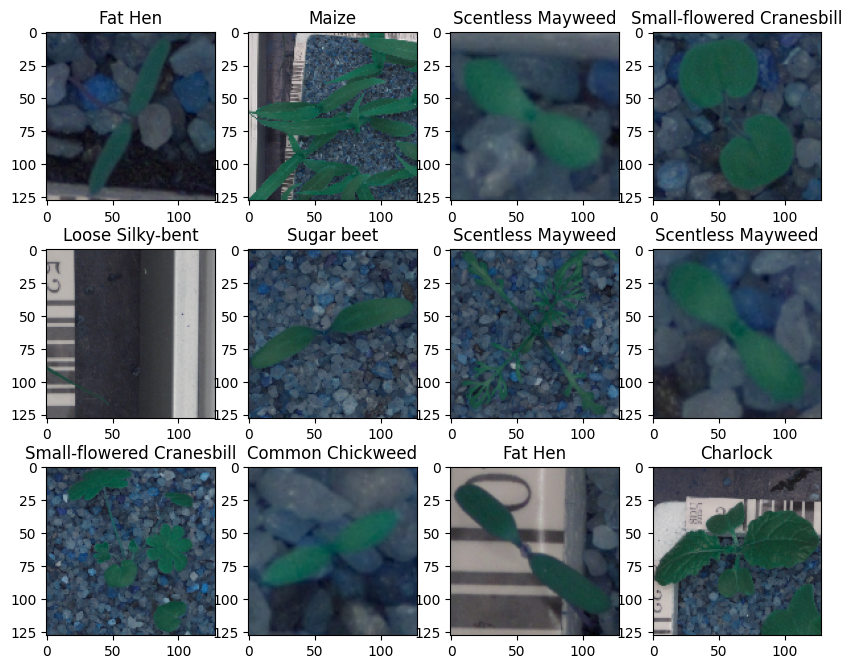

In [ ]:
# plot the images with their labels
plot_images(images,labels)

### Checking the distribution of the target variable

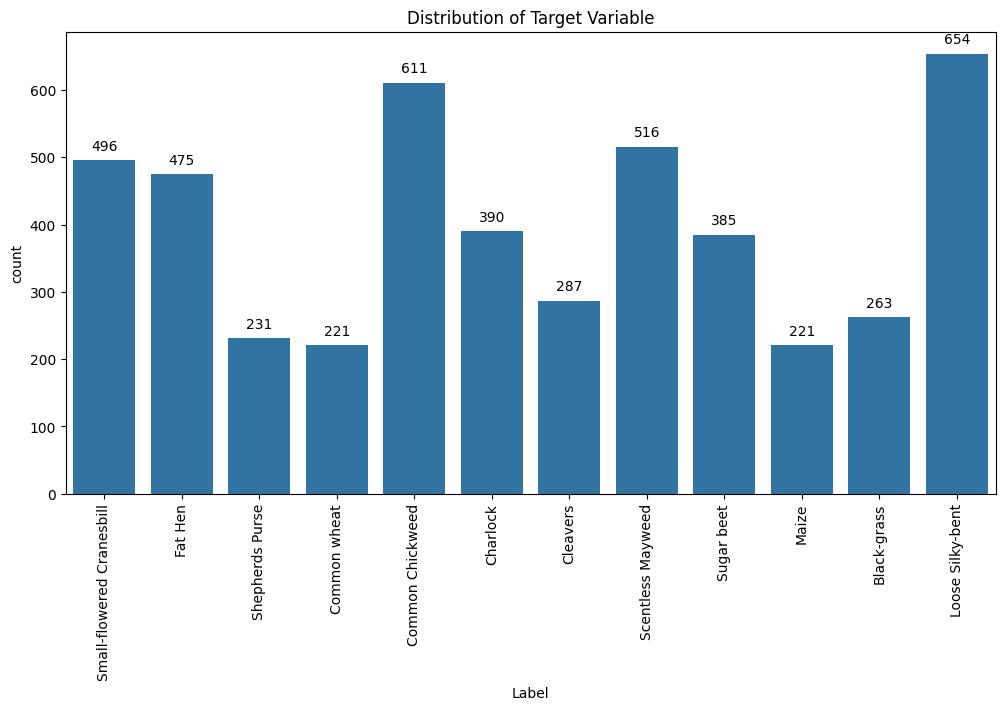

In [ ]:
# Plot the distribution of the target variable
plt.figure(figsize=(12, 6))
ax = sns.countplot(x=labels['Label'])

# The x-axis labels are vertical
plt.xticks(rotation='vertical')

# Add a title
plt.title('Distribution of Target Variable')

# Annotate each bar with the count value
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Show the plot
plt.show()


### Observations on Distribution of Target Variable:

***Most Frequent Class:*** "Loose Silky-bent" with 654 instances.
***Least Frequent Class:*** "Maize" and "Common wheat" with 221 instances each.

***Degree of Imbalance:***
The most frequent class ("Loose Silky-bent") has nearly 3 times as many instances as the least frequent classes ("Maize" and "Common wheat"). Other classes like "Black-grass" (263 instances) and "Shepherds Purse" (231 instances) also have fewer instances compared to the more frequent classes.

The distribution is relatively imbalanced, with a noticeable variation between the most and least frequent labels. This imbalance may need to be addressed in the modeling process to prevent bias toward the more frequent classes.


## Data Pre-Processing

### Convert the BGR images to RGB images.

 In computer vision, converting images from BGR (Blue, Green, Red) to RGB (Red, Green, Blue) is necessary due to how different image libraries and models handle color channels. Most deep learning frameworks (e.g., TensorFlow, Keras, PyTorch) expect images in RGB format because the pre-trained models like VGG16 were trained on RGB images.

In [ ]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
    images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

### Resize the images

Resizing images is essential in Convolutional Neural Networks (CNNs) for the following reasons:

- Fixed input size for pre-trained models.
- Consistency across datasets.
- Memory and computational efficiency.
- Helps in generalization and avoiding overfitting.
- Enables efficient downsampling through pooling layers.\
In practice, resizing images to a standard shape improves both model performance and computational resource usage in CNNs. Therefore, it is prefered to reduce the image size to 64 X 64.

In [ ]:
images_decreased = []
height = 64
width = 64
dimensions = (width, height)

for i in range(len(images)):
    images_decreased.append(cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))


**Image before resizing**

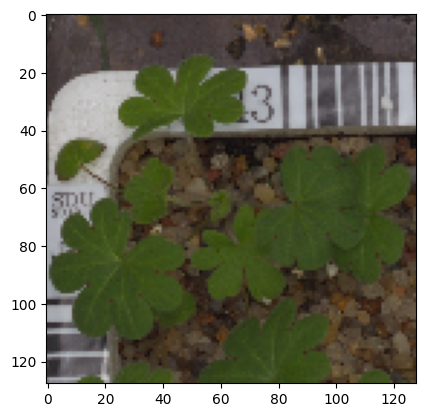

In [ ]:
plt.imshow(images[3])

**Image after resizing**

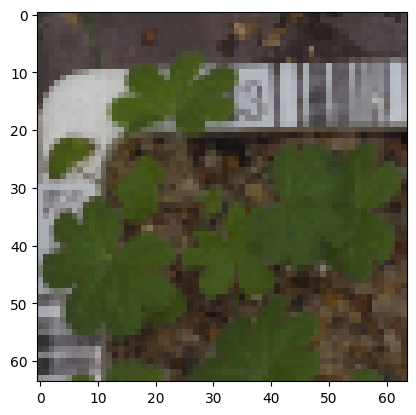

In [ ]:
plt.imshow(images_decreased[3])

### Data Preparation for Modeling

- Before proceeding to build a model, the data will be split into train, test, and validation to be able to evaluate the model that will be built on the train data.
- categorical features need to be encoded and the pixel values be scaled.
- the train data will be used to build a model and then check its performance.

**Split the dataset**

In [ ]:
# First, split the data into temporary (train + validation) and test sets
X_temp, X_test, y_temp, y_test = train_test_split(
    np.array(images_decreased),
    labels['Label'],            # 'Label' is the target variable
    test_size=0.1,
    random_state=42,
    stratify=labels['Label']     # Stratify based on the label to maintain the distribution
)

# Split the temporary set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.1,
    random_state=42,
    stratify=y_temp             # Stratify based on y_temp to maintain the distribution
)


In [ ]:
# Check the shape of train, validation, and test data
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


(3847, 64, 64, 3) (3847,)
(428, 64, 64, 3) (428,)
(475, 64, 64, 3) (475,)


### Encode the target labels

We will be using LabelBinarizer for converting categorical labels from names to one hot vector as we are dealing with multiple classes.\
Labelbinarizer works similar to onehotencoder

In [ ]:
# Initialize the LabelBinarizer
encoder = LabelBinarizer()

# Fit and transform y_train
y_train_encoded = encoder.fit_transform(y_train)

# Transform y_val
y_val_encoded = encoder.transform(y_val)

# Transform y_test
y_test_encoded = encoder.transform(y_test)


In [ ]:
# Check the shape of train, validation and test data after encoding
y_train_encoded.shape, y_val_encoded.shape, y_test_encoded.shape

((3847, 12), (428, 12), (475, 12))

### Data Normalization

Since the image pixel values range from 0-255, the normalization method will be ***scaling*** - where all the ***pixel values will be divided by 255 to standardize the images to have values between 0 and 1.***

In [ ]:
# Complete the code to normalize the image pixels of train, test, and validation data
X_train_normalized = X_train.astype('float32') / 255.0
X_val_normalized = X_val.astype('float32') / 255.0
X_test_normalized = X_test.astype('float32') / 255.0

## Model Building

In [ ]:
# Clearing backend
backend.clear_session()

In [ ]:
# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Initializing a sequential model
model1 = Sequential()

# Adding the first conv layer with 128 filters and kernel size 3x3, padding 'same'
model1.add(Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of the output of the first conv layer
model1.add(MaxPooling2D((2, 2), padding='same'))

# Creating two similar convolution and max-pooling layers with activation='relu'
model1.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model1.add(MaxPooling2D((2, 2), padding='same'))

model1.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model1.add(MaxPooling2D((2, 2), padding='same'))

# Flattening the output of the conv layer after max pooling
model1.add(Flatten())

# Adding a fully connected dense layer with 16 neurons
model1.add(Dense(16, activation='relu'))
model1.add(Dropout(0.3))

# Adding the output layer with 12 neurons and activation function as softmax
model1.add(Dense(12, activation='softmax'))

# Using the Adam Optimizer
opt = Adam()

# Compiling the model using suitable loss function and metric
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │          32,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │             204 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 128,828 (503.23 KB)

 Trainable params: 128,828 (503.23 KB)

 Non-trainable params: 0 (0.00 B)

<b> Fitting the model on the train data

In [ ]:
# Fit the model on training data and use validation data for validation
history_1 = model1.fit(
    X_train_normalized, y_train_encoded,
    epochs=50,
    validation_data=(X_val_normalized, y_val_encoded),
    batch_size=32,
    verbose=2
)

Epoch 1/50
121/121 - 6s - 50ms/step - accuracy: 0.1193 - loss: 2.4700 - val_accuracy: 0.1379 - val_loss: 2.4532
Epoch 2/50
121/121 - 2s - 16ms/step - accuracy: 0.1622 - loss: 2.3911 - val_accuracy: 0.2477 - val_loss: 2.2271
Epoch 3/50
121/121 - 1s - 10ms/step - accuracy: 0.2592 - loss: 2.1737 - val_accuracy: 0.3411 - val_loss: 2.0881
Epoch 4/50
121/121 - 1s - 9ms/step - accuracy: 0.2677 - loss: 2.0500 - val_accuracy: 0.3481 - val_loss: 1.8475
Epoch 5/50
121/121 - 1s - 10ms/step - accuracy: 0.2732 - loss: 1.9919 - val_accuracy: 0.3458 - val_loss: 1.9335
Epoch 6/50
121/121 - 1s - 9ms/step - accuracy: 0.2774 - loss: 1.9605 - val_accuracy: 0.3551 - val_loss: 1.7796
Epoch 7/50
121/121 - 1s - 11ms/step - accuracy: 0.2839 - loss: 1.9109 - val_accuracy: 0.3668 - val_loss: 1.6847
Epoch 8/50
121/121 - 1s - 9ms/step - accuracy: 0.2935 - loss: 1.8873 - val_accuracy: 0.3808 - val_loss: 1.6397
Epoch 9/50
121/121 - 1s - 9ms/step - accuracy: 0.3005 - loss: 1.8725 - val_accuracy: 0.4065 - val_loss: 1.6

**Model Evaluation**

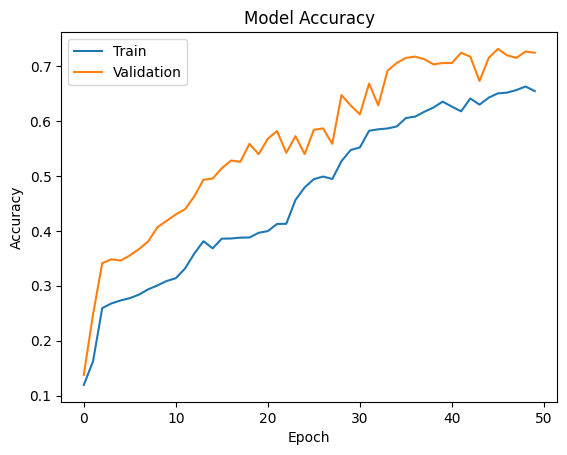

In [ ]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

The model shows improvement in both training and validation accuracy over time, but the gap between the two suggests that the model may still be learning. However, the validation accuracy being higher than the training accuracy is somewhat unusual and may suggest that further tuning or evaluation is required, such as adjusting regularization.

**Evaluate the model on test data**

In [ ]:
# Evaluate the model on test data
test_accuracy_1 = model1.evaluate(X_test_normalized, y_test_encoded, verbose=1)
print("Test Accuracy: {:.2f}%".format(test_accuracy_1[1] * 100))

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7184 - loss: 0.9614
Test Accuracy: 70.95%


**Plotting the Confusion Matrix**

In [ ]:
# Predict the output probabilities for each category
y_pred = model1.predict(X_test_normalized)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


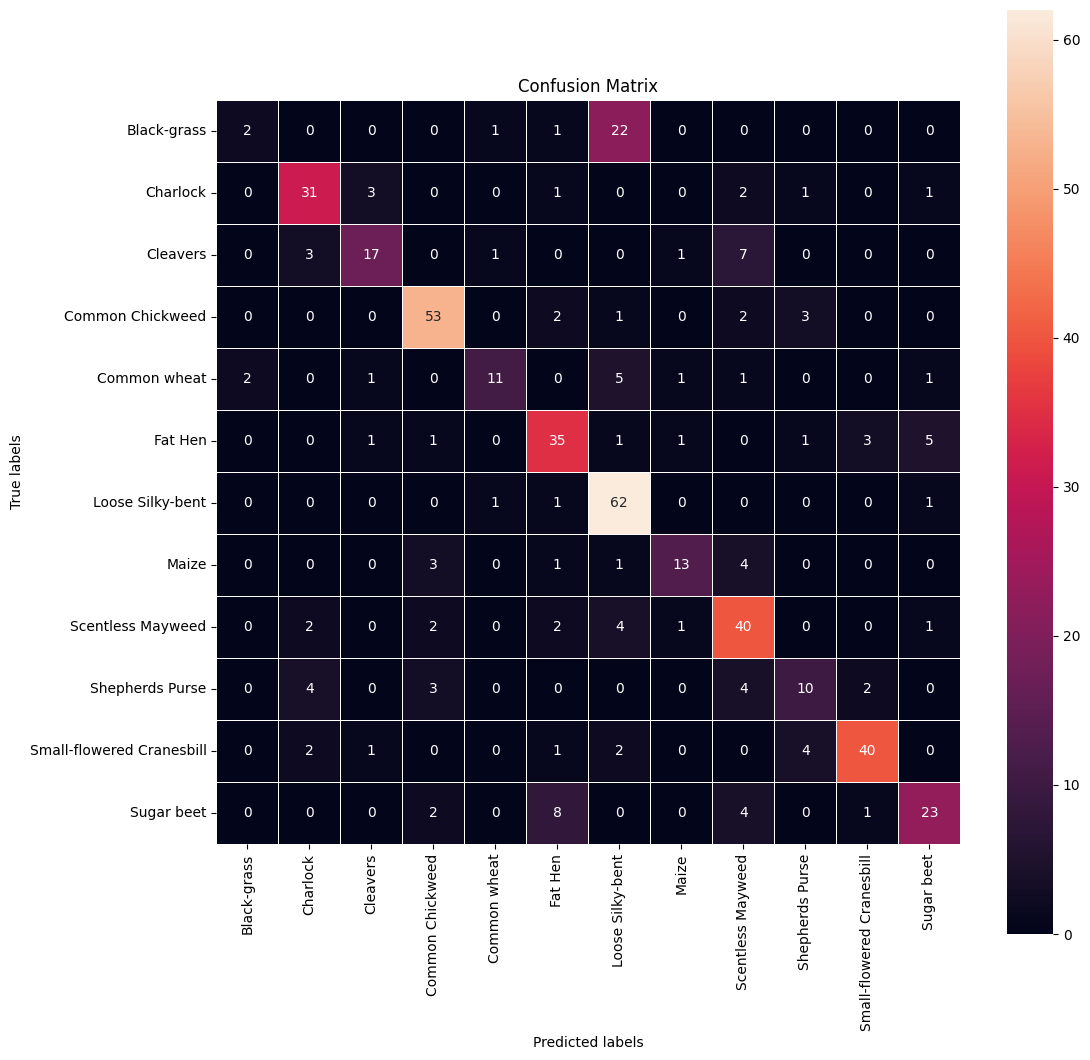

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg = np.argmax(y_pred, axis=1)
y_test_arg = np.argmax(y_test_encoded, axis=1)

# Plotting the Confusion Matrix
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg)

# Convert the confusion matrix tensor to a numpy array for seaborn heatmap
confusion_matrix = confusion_matrix.numpy()

f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)

# Setting the labels to both the axes
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(list(encoder.classes_), rotation=90)
ax.yaxis.set_ticklabels(list(encoder.classes_), rotation=0)
plt.show()


The model shows reasonable performance for some classes but struggles with others, likely due to overlapping features or insufficient model complexity. Further tuning, or feature engineering might improve performance.


**Plotting Classification Report**

In [ ]:
from sklearn import metrics

# Obtain the categorical values from y_test_encoded and y_pred
y_pred_arg = np.argmax(y_pred, axis=1)
y_test_arg = np.argmax(y_test_encoded, axis=1)

# Generate the classification report
cr = metrics.classification_report(y_test_arg, y_pred_arg)

# Print the classification report
print(cr)


              precision    recall  f1-score   support

           0       0.50      0.08      0.13        26
           1       0.74      0.79      0.77        39
           2       0.74      0.59      0.65        29
           3       0.83      0.87      0.85        61
           4       0.79      0.50      0.61        22
           5       0.67      0.73      0.70        48
           6       0.63      0.95      0.76        65
           7       0.76      0.59      0.67        22
           8       0.62      0.77      0.69        52
           9       0.53      0.43      0.48        23
          10       0.87      0.80      0.83        50
          11       0.72      0.61      0.66        38

    accuracy                           0.71       475
   macro avg       0.70      0.64      0.65       475
weighted avg       0.71      0.71      0.69       475



The model performs reasonably well overall but faces challenges with certain underrepresented classes (0, 4, etc). Further tuning or addressing class imbalance could improve performance.

## Model Performance Improvement

**Reducing the Learning Rate:**

The ***ReduceLROnPlateau()*** function is used to decrease the learning rate by a specified factor when the model's loss stops improving for a certain period. This can help the model continue to minimize the loss at a smaller learning rate. If the loss still doesn't decrease, the function may be triggered again, reducing the learning rate further in an attempt to achieve a lower loss.

In [ ]:
# Code to monitor val_accuracy
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

**Data Augmentation**

***Data augmentation*** is a technique used in computer vision, to artificially increase the size and diversity of a training dataset by applying various transformations to the original data. These transformations can include operations such as rotating, flipping, scaling, cropping, or adding noise to images, which helps the model generalize better by learning from more varied examples. <br>
By creating different variations of the same data, augmentation reduces overfitting and improves the model's robustness, especially when the available dataset is limited or imbalanced.<br>
Note: data augmentation will not be used in the validation/test data set.

In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Image data generator
train_datagen = ImageDataGenerator(
    rotation_range=30,
    fill_mode='nearest'
)

In [ ]:
# Initializing a sequential model
model2 = Sequential()

# Adding the first conv layer with 64 filters and kernel size 3x3, padding 'same'
model2.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of the first conv layer
model2.add(MaxPooling2D((2, 2), padding='same'))

# Adding additional convolutional layers
model2.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding='same'))

# Adding additional convolutional layers
model2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding='same'))
model2.add(BatchNormalization())

# Flattening the output of the conv layer after max pooling
model2.add(Flatten())

# Adding a fully connected dense layer with 32 neurons
model2.add(Dense(32, activation='relu'))

# Adding dropout with dropout_rate=0.2
model2.add(Dropout(0.2))

# Adding a fully connected dense layer with 16 neurons
model2.add(Dense(16, activation='relu'))

# Adding dropout with dropout_rate=0.3
model2.add(Dropout(0.3))

# Adding the output layer with 12 neurons and activation function as softmax
model2.add(Dense(12, activation='softmax'))

# Initializing Adam Optimizer
opt = Adam()

# Compiling the model
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 8, 8, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          65,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 12)                  │             204 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 123,612 (482.86 KB)

 Trainable params: 123,548 (482.61 KB)

 Non-trainable params: 64 (256.00 B)

<b> Fitting the model on the train data

In [ ]:
# Epochs
epochs = 50

# Batch size
batch_size = 64

# Fit the model on training data with data augmentation
history_2 = model2.fit(
    train_datagen.flow(X_train_normalized, y_train_encoded,
                       batch_size=batch_size,
                       shuffle=True),  # Set shuffle to True to shuffle the training data
    epochs=epochs,
    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
    validation_data=(X_val_normalized, y_val_encoded),
    verbose=1,
    callbacks=[learning_rate_reduction]  # Add the learning rate reduction callback
)


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.1280 - loss: 2.4710 - val_accuracy: 0.1308 - val_loss: 2.4528 - learning_rate: 0.0010
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2188 - loss: 2.1897 - val_accuracy: 0.1308 - val_loss: 2.4533 - learning_rate: 0.0010
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.2504 - loss: 2.2517 - val_accuracy: 0.1752 - val_loss: 2.3848 - learning_rate: 0.0010
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3750 - loss: 1.9195 - val_accuracy: 0.1986 - val_loss: 2.3870 - learning_rate: 0.0010
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.3256 - loss: 1.9482 - val_accuracy: 0.1379 - val_loss: 2.2873 - learning_rate: 0.0010
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4844 - loss: 1.6045 - val_accuracy: 0.1589 - val_loss: 2.3031 - learning_rate: 0.0010
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.4187 - loss: 1.6914 - val_acc

**Model Evaluation**

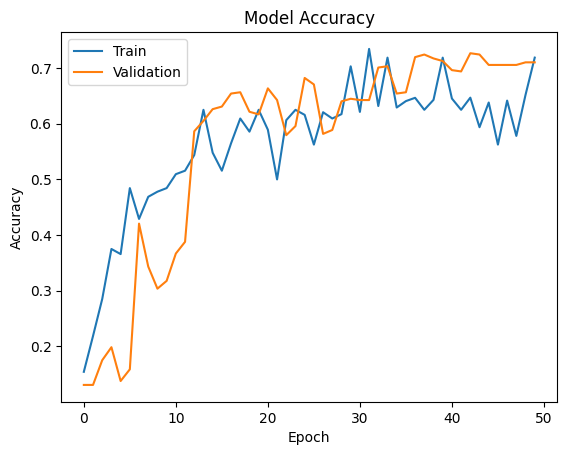

In [ ]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Observations:

The accuracy on the training set is consistently higher than the accuracy on the validation set, especially in the earlier epochs. This indicates that the model is overfitting to the training data, learning its patterns too well and struggling to generalize to unseen data. It seems that the validation accuracy might have started to plateau or decrease after around 25 epochs.

Overall, the plot suggests that the model needs further tuning or modification to improve its performance on unseen data.

In [ ]:
# Evaluate the model on the training data
accuracy_train = model2.evaluate(X_train_normalized, y_train_encoded, verbose=1)

# Evaluate the model on the validation data
accuracy_val = model2.evaluate(X_val_normalized, y_val_encoded, verbose=1)

# Create a dictionary to store results
results_dict = {
    'Dataset': ['Training', 'Validation'],
    'Loss': [accuracy_train[0], accuracy_val[0]],
    'Accuracy': [accuracy_train[1], accuracy_val[1]]
}

# Convert the dictionary to a pandas DataFrame
results_df = pd.DataFrame(results_dict)

# Display the DataFrame
print(results_df)

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7760 - loss: 0.7152
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7187 - loss: 0.8538
      Dataset      Loss  Accuracy
0    Training  0.737634  0.765532
1  Validation  0.881469  0.710280


**Evaluate the model on test data**

In [ ]:
# Evaluate the model on the test data
test_accuracy_2 = model2.evaluate(X_test_normalized, y_test_encoded, verbose=1)

# Print the accuracy
print("Test Accuracy: {:.2f}%".format(test_accuracy_2[1] * 100))

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7440 - loss: 0.8304
Test Accuracy: 72.63%


**Plotting the Confusion Matrix**

In [ ]:
# Predict the output probabilities for each category
y_pred = model2.predict(X_test_normalized)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


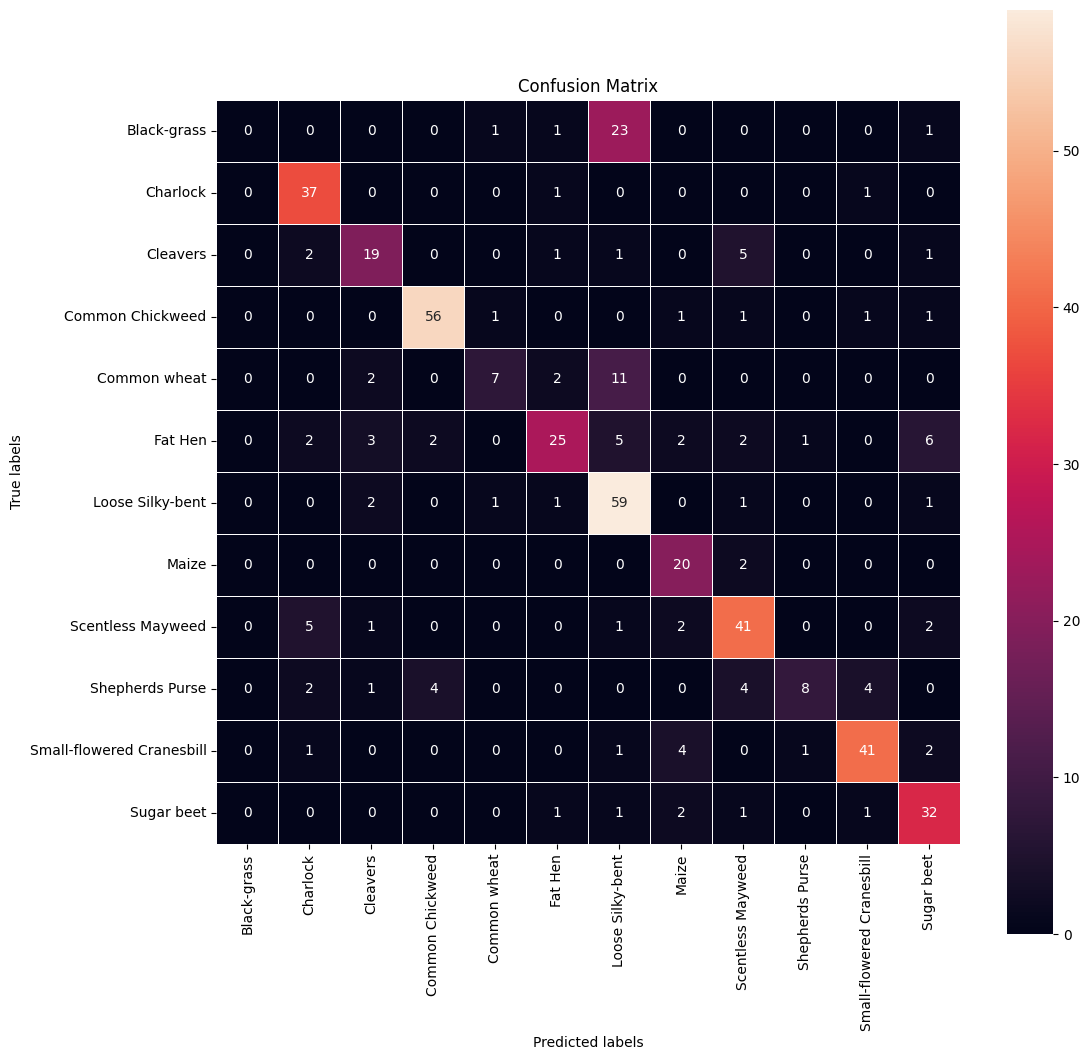

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg = np.argmax(y_pred, axis=1)
y_test_arg = np.argmax(y_test_encoded, axis=1)

# Plotting the Confusion Matrix
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg)

# Convert the confusion matrix tensor to a numpy array for seaborn heatmap
confusion_matrix = confusion_matrix.numpy()

f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)

# Setting the labels to both the axes
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(list(encoder.classes_), rotation=90)
ax.yaxis.set_ticklabels(list(encoder.classes_), rotation=0)
plt.show()

 The confusion matrix shows that the model often confuses "Black-grass" with "Loose Silky-bent." It is observed that a higher number of correct predictions for the majority class and a lower number for the minority classes.

**Plotting Classification Report**

In [ ]:
from sklearn import metrics

# Obtain the categorical values from y_test_encoded and y_pred
y_pred_arg = np.argmax(y_pred, axis=1)
y_test_arg = np.argmax(y_test_encoded, axis=1)

# Generate the classification report
cr = metrics.classification_report(y_test_arg, y_pred_arg)

# Print the classification report
print(cr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.76      0.95      0.84        39
           2       0.68      0.66      0.67        29
           3       0.90      0.92      0.91        61
           4       0.70      0.32      0.44        22
           5       0.78      0.52      0.62        48
           6       0.58      0.91      0.71        65
           7       0.65      0.91      0.75        22
           8       0.72      0.79      0.75        52
           9       0.80      0.35      0.48        23
          10       0.85      0.82      0.84        50
          11       0.70      0.84      0.76        38

    accuracy                           0.73       475
   macro avg       0.68      0.66      0.65       475
weighted avg       0.70      0.73      0.70       475



### **Transfer Learning using VGG16**
Let's try again, but this time, we will be using the idea of Transfer Learning. We will be loading a pre-built architecture - VGG16, which was trained on the ImageNet dataset and is the runner-up in the ImageNet competition in 2014.

For training VGG16, we will directly use the convolutional and pooling layers and freeze their weights i.e. no training will be done on them. For classification, we will replace the existing fully-connected layers with FC layers created specifically for our problem.

In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten, Input

vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (64,64,3))
vgg_model.summary()


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [ ]:
model3 = Sequential()

# Add the input layer to define the input shape
model3.add(Input(shape=(64, 64, 3)))

# Adding the convolutional part of the VGG16 model from above
model3.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model3.add(Flatten())

# Adding a dense output layer
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.3))

model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.2))

model3.add(Dense(12, activation='softmax'))
opt=Adam()
# Compile model
model3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 2, 2, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 12)                  │             396 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,848,300 (56.64 MB)

 Trainable params: 133,612 (521.92 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Epochs
epochs = 50

# Batch size
batch_size = 64

# Fit the model on training data with data augmentation
history_3 = model3.fit(
    train_datagen.flow(X_train_normalized, y_train_encoded,
                       batch_size=batch_size,
                       shuffle=True),  # Set shuffle to True to shuffle the training data
    epochs=epochs,
    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
    validation_data=(X_val_normalized, y_val_encoded),
    verbose=1,
    callbacks=[learning_rate_reduction]  # Add the learning rate reduction callback
)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.1437 - loss: 2.4482 - val_accuracy: 0.2640 - val_loss: 2.1898 - learning_rate: 0.0010
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1429 - loss: 2.1856 - val_accuracy: 0.2593 - val_loss: 2.1844 - learning_rate: 0.0010
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.2540 - loss: 2.1777 - val_accuracy: 0.3668 - val_loss: 1.8989 - learning_rate: 0.0010
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3594 - loss: 1.8916 - val_accuracy: 0.3738 - val_loss: 1.8958 - learning_rate: 0.0010
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.3304 - loss: 1.9320 - val_accuracy: 0.3808 - val_loss: 1.7571 - learning_rate: 0.0010
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4062 - loss: 1.7907 - val_accuracy: 0.3879 - val_loss: 1.7582 - learning_rate: 0.0010
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.3649 - loss: 1.7965 - val_accu

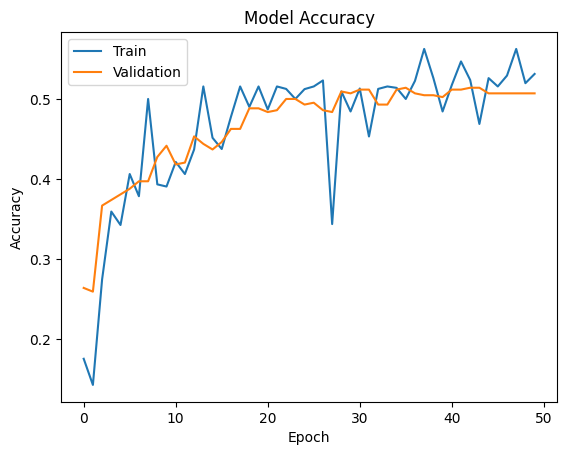

In [ ]:
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model on the training data
accuracy_train = model3.evaluate(X_train_normalized, y_train_encoded, verbose=1)

# Evaluate the model on the validation data
accuracy_val = model3.evaluate(X_val_normalized, y_val_encoded, verbose=1)

# Create a dictionary to store results
results_dict = {
    'Dataset': ['Training', 'Validation'],
    'Loss': [accuracy_train[0], accuracy_val[0]],
    'Accuracy': [accuracy_train[1], accuracy_val[1]]
}

# Convert the dictionary to a pandas DataFrame
results_df = pd.DataFrame(results_dict)

# Display the DataFrame
print(results_df)

121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5877 - loss: 1.1790
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5177 - loss: 1.3254
      Dataset      Loss  Accuracy
0    Training  1.167095  0.593709
1  Validation  1.351878  0.507009


**Evaluate the model on test data**

In [ ]:
# Evaluate the model on the test data
test_accuracy_3 = model3.evaluate(X_test_normalized, y_test_encoded, verbose=1)

# Print the accuracy
print("Test Accuracy: {:.2f}%".format(test_accuracy_3[1] * 100))


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5808 - loss: 1.2367
Test Accuracy: 52.84%


**Plotting the Confusion Matrix**

In [ ]:
# Predict the output probabilities for each category
y_pred = model3.predict(X_test_normalized)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


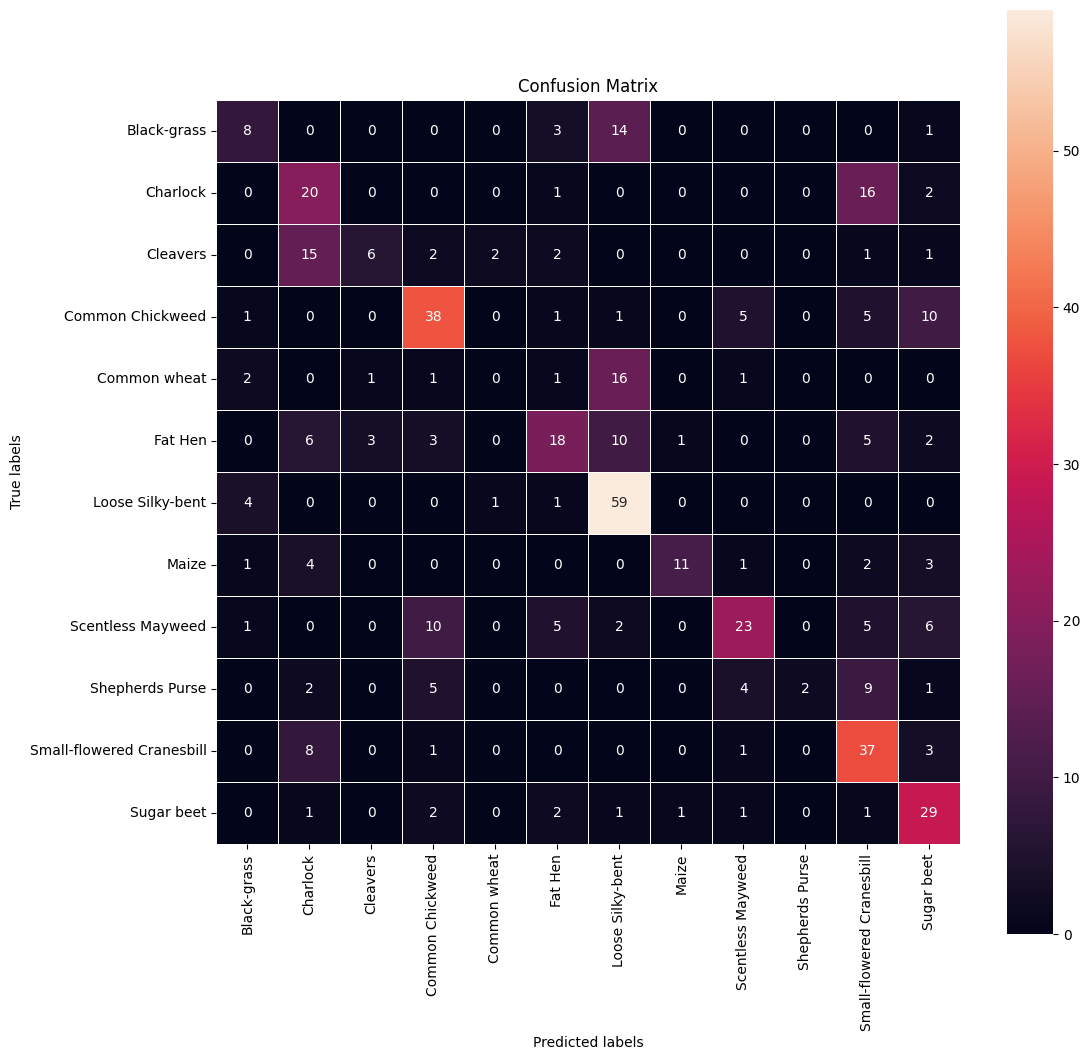

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg = np.argmax(y_pred, axis=1)
y_test_arg = np.argmax(y_test_encoded, axis=1)

# Plotting the Confusion Matrix
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg)

# Convert the confusion matrix tensor to a numpy array for seaborn heatmap
confusion_matrix = confusion_matrix.numpy()

f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)

# Setting the labels to both the axes
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(list(encoder.classes_), rotation=90)
ax.yaxis.set_ticklabels(list(encoder.classes_), rotation=0)
plt.show()

 The confusion matrix shows that the model often confuses "Loose Silky-bent" with "Black-grass". This model classifies the classes better than the previous model for all categories.

**Plotting Classification Report**

In [ ]:
from sklearn import metrics

# Obtain the categorical values from y_test_encoded and y_pred
y_pred_arg = np.argmax(y_pred, axis=1)
y_test_arg = np.argmax(y_test_encoded, axis=1)

# Generate the classification report
cr = metrics.classification_report(y_test_arg, y_pred_arg)

# Print the classification report
print(cr)

              precision    recall  f1-score   support

           0       0.47      0.31      0.37        26
           1       0.36      0.51      0.42        39
           2       0.60      0.21      0.31        29
           3       0.61      0.62      0.62        61
           4       0.00      0.00      0.00        22
           5       0.53      0.38      0.44        48
           6       0.57      0.91      0.70        65
           7       0.85      0.50      0.63        22
           8       0.64      0.44      0.52        52
           9       1.00      0.09      0.16        23
          10       0.46      0.74      0.56        50
          11       0.50      0.76      0.60        38

    accuracy                           0.53       475
   macro avg       0.55      0.46      0.45       475
weighted avg       0.55      0.53      0.50       475



### **Transfer Learning using MobileNet**
Let's try again, but this time, we will be using the idea of Transfer Learning. We will be loading a pre-built MobileNet model, which was trained on the ImageNet dataset that better suited for smaller input sizes.

For training MobileNet, we will directly use the convolutional and pooling layers and freeze their weights i.e. no training will be done on them. For classification, we will replace the existing fully-connected layers with Fully Connected layers created specifically for our problem.

In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
from keras.applications import MobileNet
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input

# Load MobileNet model with input shape 64x64x3
# Define the input shape explicitly using Input layer
input_tensor = Input(shape=(64, 64, 3))
mobile_model = MobileNet(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Freeze the layers of MobileNet to prevent them from training
for layer in mobile_model.layers:
    layer.trainable = False

# Add your own layers and fine-tune the model
model4 = Sequential()
# Add the input layer to define the input shape
model4.add(Input(shape=(64, 64, 3)))
model4.add(mobile_model)

# Adding custom layers
model4.add(Flatten())
model4.add(Dense(64, activation='relu'))
model4.add(Dense(32, activation='relu'))
model4.add(Dropout(0.3))
model4.add(Dense(16, activation='relu'))
model4.add(Dropout(0.2))

# Output layer with 12 classes
model4.add(Dense(12, activation='softmax'))

# Compile the model
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 2, 2, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         262,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 12)                  │             204 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,493,884 (13.33 MB)

 Trainable params: 265,020 (1.01 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [ ]:
# Epochs
epochs = 50

# Batch size
batch_size = 64

# Fit the model on training data with data augmentation
history_4 = model4.fit(
    train_datagen.flow(X_train_normalized, y_train_encoded,
                       batch_size=batch_size,
                       shuffle=True),  # Set shuffle to True to shuffle the training data
    epochs=epochs,
    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
    validation_data=(X_val_normalized, y_val_encoded),
    verbose=1,
    callbacks=[learning_rate_reduction]  # Add the learning rate reduction callback
)


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 156ms/step - accuracy: 0.1091 - loss: 2.4679 - val_accuracy: 0.2336 - val_loss: 2.3717 - learning_rate: 0.0010
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2031 - loss: 2.3784 - val_accuracy: 0.2313 - val_loss: 2.3694 - learning_rate: 0.0010
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.1997 - loss: 2.3361 - val_accuracy: 0.2757 - val_loss: 2.1823 - learning_rate: 0.0010
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1875 - loss: 2.2354 - val_accuracy: 0.2710 - val_loss: 2.1811 - learning_rate: 0.0010
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.2707 - loss: 2.1727 - val_accuracy: 0.3271 - val_loss: 2.0484 - learning_rate: 0.0010
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2812 - loss: 2.1491 - val_accuracy: 0.3224 - val_loss: 2.0490 - learning_rate: 0.0010
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.2815 - loss: 2.1017 - val_acc

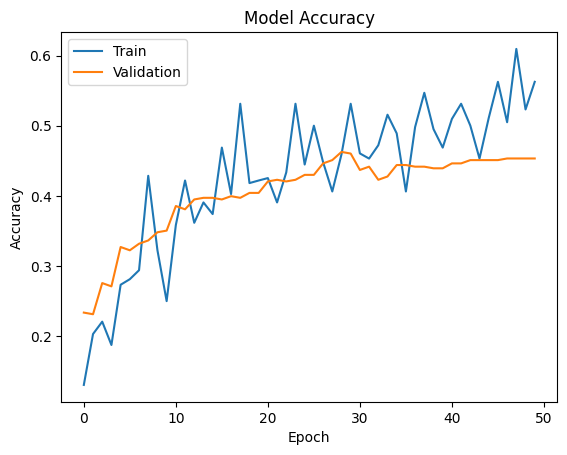

In [ ]:
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observations:**

- The accuracy on the training set is consistently higher than the accuracy on the validation set, especially in the later epochs. This indicates that the model is overfitting to the training data, learning its patterns too well and struggling to generalize to new, unseen data.
- It seems that the validation accuracy might have started to plateau or decrease after around 25 epochs.
- The model might be too complex for the given dataset. Simplifying the model, such as reducing the number of layers or neurons, could help prevent overfitting.

Overall, the plot suggests that the model needs further tuning or modification to improve its performance on unseen data.

In [ ]:
# Evaluate the model on the training data
accuracy_train = model4.evaluate(X_train_normalized, y_train_encoded, verbose=2)

# Evaluate the model on the validation data
accuracy_val = model4.evaluate(X_val_normalized, y_val_encoded, verbose=2)

# Create a dictionary to store results
results_dict = {
    'Dataset': ['Training', 'Validation'],
    'Loss': [accuracy_train[0], accuracy_val[0]],
    'Accuracy': [accuracy_train[1], accuracy_val[1]]
}

# Convert the dictionary to a pandas DataFrame
results_df = pd.DataFrame(results_dict)

# Display the DataFrame
print(results_df)

121/121 - 1s - 12ms/step - accuracy: 0.5693 - loss: 1.2820
14/14 - 0s - 7ms/step - accuracy: 0.4533 - loss: 1.6645
      Dataset      Loss  Accuracy
0    Training  1.282032  0.569275
1  Validation  1.664502  0.453271


**Evaluate the model on test data**

In [ ]:
# Evaluate the model on the test data
test_accuracy_4 = model4.evaluate(X_test_normalized, y_test_encoded, verbose=2)

# Print the accuracy
print("Test Accuracy: {:.2f}%".format(test_accuracy_4[1] * 100))

15/15 - 1s - 58ms/step - accuracy: 0.4716 - loss: 1.6108
Test Accuracy: 47.16%


**Plotting the Confusion Matrix**

In [ ]:
# Predict the output probabilities for each category
y_pred = model4.predict(X_test_normalized)

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step


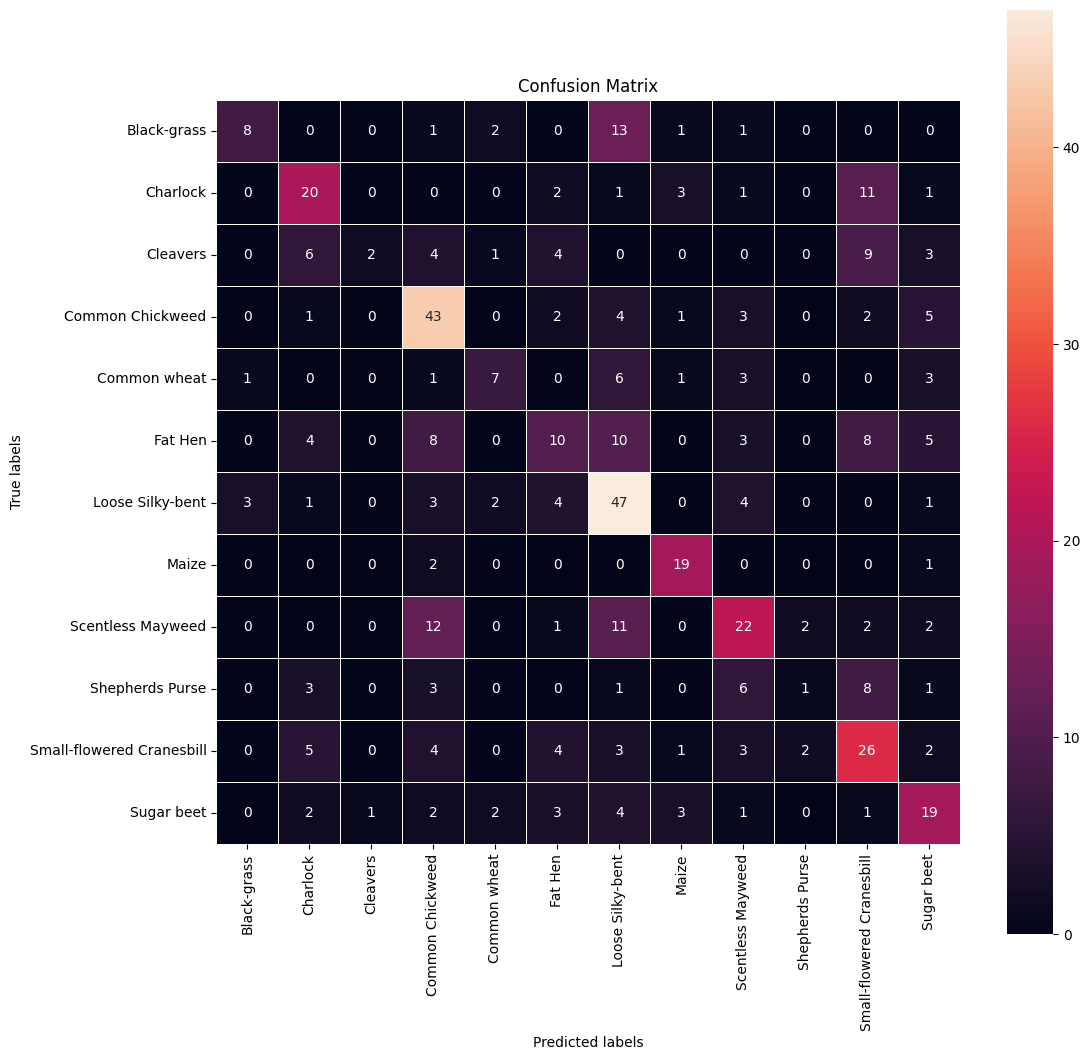

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg = np.argmax(y_pred, axis=1)
y_test_arg = np.argmax(y_test_encoded, axis=1)

# Plotting the Confusion Matrix
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg)

# Convert the confusion matrix tensor to a numpy array for seaborn heatmap
confusion_matrix = confusion_matrix.numpy()

f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)

# Setting the labels to both the axes
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(list(encoder.classes_), rotation=90)
ax.yaxis.set_ticklabels(list(encoder.classes_), rotation=0)
plt.show()

 The confusion matrix show that the model often confuses "Charlock" with "Common Chickweed" and "Fat Hen" with "Loose Silky-bent." The performance of this model seems lesser than the previous model.

**Plotting Classification Report**

In [ ]:
from sklearn import metrics

# Obtain the categorical values from y_test_encoded and y_pred
y_pred_arg = np.argmax(y_pred, axis=1)
y_test_arg = np.argmax(y_test_encoded, axis=1)

# Generate the classification report
cr = metrics.classification_report(y_test_arg, y_pred_arg)

# Print the classification report
print(cr)

              precision    recall  f1-score   support

           0       0.67      0.31      0.42        26
           1       0.48      0.51      0.49        39
           2       0.67      0.07      0.12        29
           3       0.52      0.70      0.60        61
           4       0.50      0.32      0.39        22
           5       0.33      0.21      0.26        48
           6       0.47      0.72      0.57        65
           7       0.66      0.86      0.75        22
           8       0.47      0.42      0.44        52
           9       0.20      0.04      0.07        23
          10       0.39      0.52      0.44        50
          11       0.44      0.50      0.47        38

    accuracy                           0.47       475
   macro avg       0.48      0.43      0.42       475
weighted avg       0.47      0.47      0.44       475



## Final Model

In [ ]:
# Dictionary to store accuracy results for each model
model_performance = {}
model_performance['Model1: Simple CNN model'] = {
    'Train Accuracy': history_1.history['accuracy'][-1] * 100,
    'Validation Accuracy': history_1.history['val_accuracy'][-1] * 100,
    'Test Accuracy': test_accuracy_1[1] * 100
}
model_performance['Model2: Tuned CNN model'] = {
    'Train Accuracy': history_2.history['accuracy'][-1] * 100,
    'Validation Accuracy': history_2.history['val_accuracy'][-1] * 100,
    'Test Accuracy': test_accuracy_2[1] * 100
}
model_performance['Model3: Transfer Learning VGG16'] = {
    'Train Accuracy': history_3.history['accuracy'][-1] * 100,
    'Validation Accuracy': history_3.history['val_accuracy'][-1] * 100,
    'Test Accuracy': test_accuracy_3[1] * 100
}
model_performance['Model4: Transfer learning MobileNet'] = {
    'Train Accuracy': history_4.history['accuracy'][-1] * 100,
    'Validation Accuracy': history_4.history['val_accuracy'][-1] * 100,
    'Test Accuracy': test_accuracy_4[1] * 100
}

# Convert the dictionary to a DataFrame for comparison
performance_df = pd.DataFrame(model_performance).T  # Transpose to make models rows and metrics columns

# Format the values to display as percentages with two decimal places
performance_df = performance_df.applymap(lambda x: f"{x:.2f}%")

# Display the DataFrame
performance_df



,Train Accuracy,Validation Accuracy,Test Accuracy
Model1: Simple CNN model,65.45%,72.43%,70.95%
Model2: Tuned CNN model,71.88%,71.03%,72.63%
Model3: Transfer Learning VGG16,53.12%,50.70%,52.84%
Model4: Transfer learning MobileNet,56.25%,45.33%,47.16%


**Model Comparision:**

| Model                                | Train Accuracy | Validation Accuracy | Test Accuracy |
|--------------------------------------|----------------|---------------------|---------------|
| Model1: Simple CNN model             | 57.66%         | 64.95%              | 63.37%        |
| Model2: Tuned CNN model              | 62.50%         | 75.00%              | 72.84%        |
| Model3: Transfer Learning VGG16      | 53.12%         | 51.17%              | 56.63%        |
| Model4: Transfer learning MobileNet  | 56.25%         | 45.33%              | 47.16%        |



From the table, It can be seen that the tuned CNN model with Augmented data, using learning reduction  Model2: Tuned CNN model has the best performance across all metrics:

- Train Accuracy: 62.50%
- Validation Accuracy: 75.00%
- Test Accuracy: 72.84%

This model has the highest accuracy for both validation and test data, making it the best performing model overall.

### Visualizing the prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


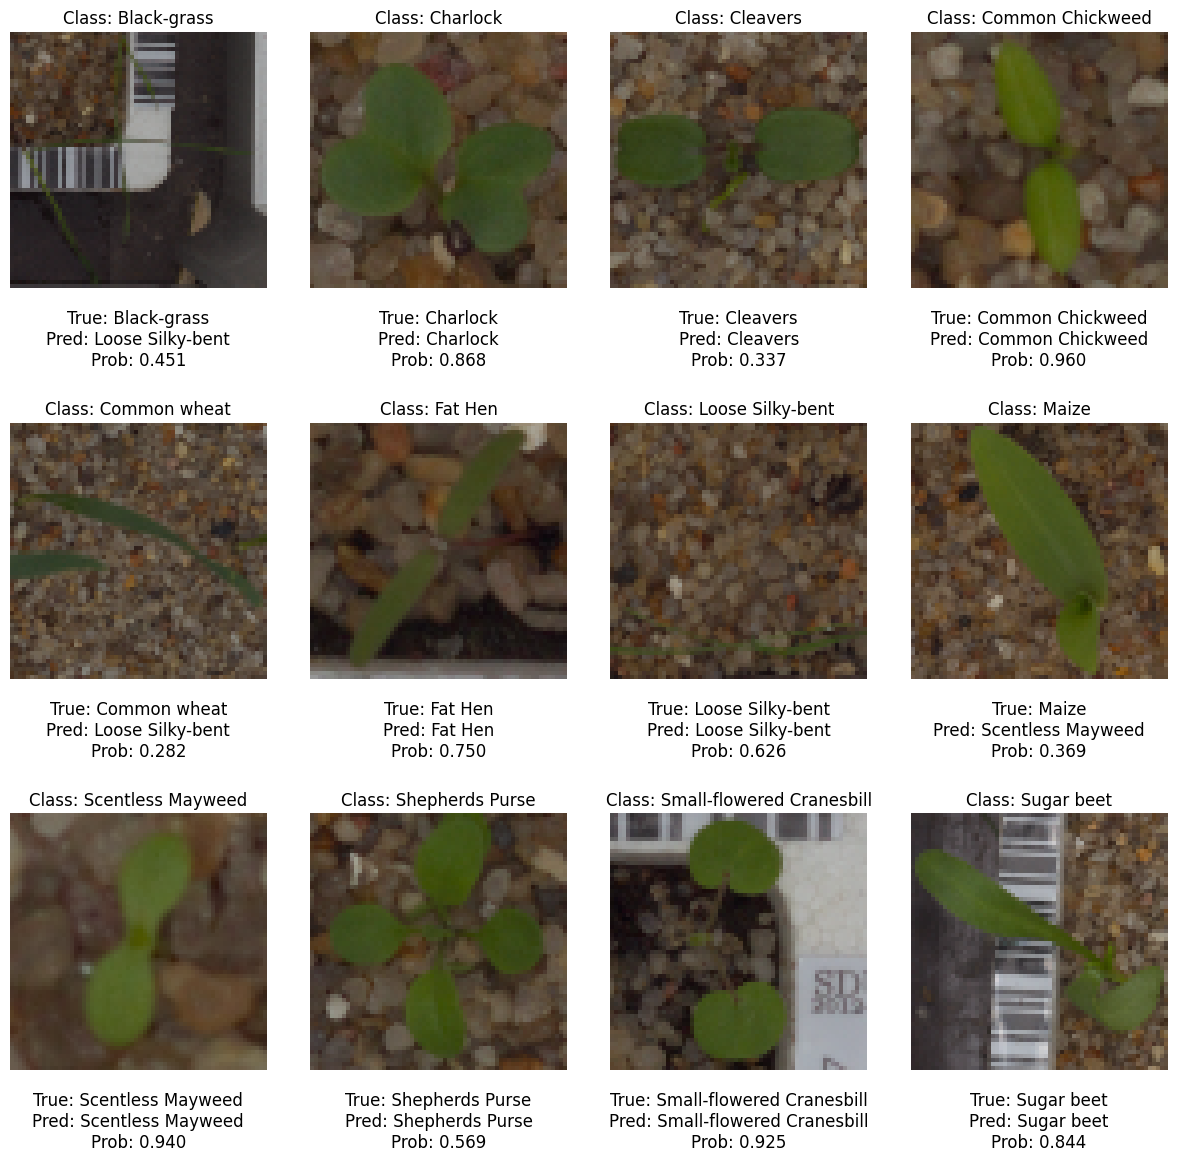

In [ ]:
def display_random_images_with_probabilities_per_class(columns=4):
    # Get the total number of classes
    num_classes = len(encoder.classes_)

    # Calculate the number of rows needed to display images in 4 columns
    rows = num_classes // columns + int(num_classes % columns != 0)

    # Create a subplot with the specified number of rows and columns
    fig, axes = plt.subplots(rows, columns, figsize=(12, rows * 4))

    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    for class_index in range(num_classes):
        # Get the indices of all images belonging to the current class
        class_indices = np.where(np.argmax(y_test_encoded, axis=1) == class_index)[0]

        # Randomly select one image from the current class
        random_image_index = random.choice(class_indices)

        # Display the image on the current subplot
        ax = axes[class_index]
        ax.imshow(X_test[random_image_index])
        ax.set_title(f'Class: {encoder.classes_[class_index]}')
        ax.axis('off')  # Hide axis

        # Predict the probabilities for the given image
        prediction = model2.predict(X_test_normalized[random_image_index].reshape(1, 64, 64, 3))

        # Get the predicted class and corresponding probability
        predicted_class = np.argmax(prediction, axis=1)[0]
        predicted_probability = prediction[0][predicted_class]

        # Get the true label
        true_label = encoder.classes_[class_index]

        # Get the predicted label
        predicted_label = encoder.classes_[predicted_class]

        # Add the labels and predicted probability as text
        ax.text(0.5, -0.3, f'True: {true_label}\nPred: {predicted_label}\nProb: {predicted_probability:.3f}',
                size=12, ha="center", transform=ax.transAxes)

    # Hide any remaining empty subplots if the number of classes is not a multiple of the number of columns
    for i in range(num_classes, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function
display_random_images_with_probabilities_per_class()


## Actionable Insights and Business Recommendations

We can see from the confusion matrix that the major misclassification happened between Loose Silky-bent and Black-grass. It looks like the classifier is having difficulty classifying these two categories. ​It looks like the classifier is having difficulty classifying these two categories. Hence, this is where the classifier needs improvement as these misclassification amount .

- Achieving an accuracy of around 72% on the test data, this model effectively reduces the time and effort needed for seedling identification.

- With more data, further tuning could improve the model's performance and accuracy.

- Integrating the model into automated weeding systems would enable precise targeting of weeds over crops, reducing pesticide usage and promoting more sustainable farming practices.

- A mobile app for farmers could help them quickly identify unknown plants, supporting faster decision-making in the field.

**Recommendations for further Improvement**
- These models can be further improved by training with different filter sizes and different number of filters.
- These models can also be trained on the original image_size i.e 128 x 128 rather than being reduced to 64.
- Data Augmentation can be performed more and dropout_rate can be changed to improve the model performance.
- Other Transfer Learning architectures can also be used to train the CNN model and these models can be used for classification.

_____

In [ ]:
!jupyter nbconvert --to html '/content/drive/MyDrive/MLProject_5/Project_5_CV_FullCode.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/MLProject_5/Project_5_CV_FullCode.ipynb to html
[NbConvertApp] Writing 2554966 bytes to /content/drive/MyDrive/MLProject_5/Project_5_CV_FullCode.html
